In [2]:
import matplotlib.pyplot as plt
import nibabel as nib
import random
import numpy as np
from skimage import transform
from collections import OrderedDict
import json
from pathlib import Path
from torchvision import transforms
from sklearn.model_selection import train_test_split
import skimage.transform as skTrans


In [3]:
def find_pix_dim(vol_img) :
    
    pix_dim = vol_img.header['pixdim']
    dim = vol_img.header['dim']
    max_indx = np.argmax(dim)
    pixdimX = pix_dim[max_indx]
    dim = np.delete(pix_dim, max_indx)
    max_indy = np.argmax(dim)
    pixdimY = pix_dim[max_indy]
    return [pixdimX, pixdimY]



def preprocess_data(img, mask, config, config_encoder, pixel_size, pixel_size_target, data=0) :

    nx, ny = config_encoder["resize_size"]
    crop_size = config['crop_size']

    scale_vector = [pixel_size[0]/pixel_size_target[0], pixel_size[1]/pixel_size_target[1]]
    print(scale_vector)
    
    for slice_no in range(img.shape[2]) :
        slice_img = np.squeeze(img[:, :, slice_no])
        if mask is not None :
            slice_mask = np.squeeze(mask[:, :, slice_no])
            if data == 1 :
                slice_mask[slice_mask == 4] = 3
        #print('original ', slice_img.shape)
        img_rescaled = transform.rescale(slice_img,
                                          scale_vector,
                                          order= 1,
                                          preserve_range = True,
                                          mode = 'constant')
        if mask is not None :
            mask_rescaled = transform.rescale(slice_mask,
                                              scale_vector,
                                              order= 0,
                                              preserve_range = True,
                                              mode = 'constant',
                                              anti_aliasing = False)
        #print('rescale ',img_rescaled.shape)
        img_cropped = crop_or_pad_slice_to_size(img_rescaled, nx, ny )
        if mask is not None :
            mask_cropped = crop_or_pad_slice_to_size(mask_rescaled, nx, ny )
        #print('cropped ', img_cropped.shape)
        #img_resized =  skTrans.resize(img_cropped, [nx, ny], order=1, preserve_range=True)
        #if mask is not None :
        #    mask_resized =  skTrans.resize(mask_cropped, [nx, ny], order=0, preserve_range=True, anti_aliasing = False)
        
        if(slice_no == 0) :
            imgs_cropped = np.reshape(img_cropped, (nx,ny,1))
            if mask is not None :
                masks_cropped = np.reshape(mask_cropped, (nx,ny,1))
        else :
            img_cropped_tmp = np.reshape(img_cropped, (nx,ny,1))
            imgs_cropped = np.concatenate((imgs_cropped, img_cropped_tmp), axis=2)
            if mask is not None :
                mask_cropped_tmp = np.reshape(mask_cropped, (nx,ny,1))
                masks_cropped = np.concatenate((masks_cropped, mask_cropped_tmp), axis=2)
    if mask is not None :
        return imgs_cropped, masks_cropped
    else: 
        return imgs_cropped

    

def normalize_minmax_data(image_data,min_val=1,max_val=99):
    """
    # 3D MRI scan is normalized to range between 0 and 1 using min-max normalization.
    Here, the minimum and maximum values are used as 1st and 99th percentiles respectively from the 3D MRI scan.
    We expect the outliers to be away from the range of [0,1].
    input params :
        image_data : 3D MRI scan to be normalized using min-max normalization
        min_val : minimum value percentile
        max_val : maximum value percentile
    returns:
        final_image_data : Normalized 3D MRI scan obtained via min-max normalization.
    """
    min_val_1p=np.percentile(image_data,min_val)
    max_val_99p=np.percentile(image_data,max_val)
    final_image_data=np.zeros((image_data.shape[0],image_data.shape[1],image_data.shape[2]), dtype=np.float64)
    # min-max norm on total 3D volume
    final_image_data=(image_data-min_val_1p)/(max_val_99p-min_val_1p)
    
    return final_image_data

def crop_or_pad_slice_to_size(img_slice, nx, ny):
    slice_cropped = np.zeros((nx,ny))
    x, y = img_slice.shape
    
    x_s = (x-nx) // 2
    y_s = (y-ny) // 2
    x_c = (nx-x) // 2
    y_c = (ny-y) // 2
    
    if x > nx and y > ny:
        slice_cropped = img_slice[x_s:x_s+nx, y_s:y_s+ny]
    else :
        slice_cropped = np.zeros((nx, ny))
        if x <= nx and y > ny :
            slice_cropped[x_c:x_c+x, :] = img_slice[:, y_s:y_s + ny]
        elif x > nx and y <= ny:
            slice_cropped[:, y_c:y_c + y] = img_slice[x_s:x_s + nx, :]
        else:
            slice_cropped[x_c:x_c + x, y_c:y_c + y] = img_slice[:, :]

    return slice_cropped

def visualize_data(data_dir1, data_dir2, data_dir3, data_dir4) :    
    
    data = nib.load(data_dir1)
    image_data1 = data.get_fdata()
    
    data = nib.load(data_dir2)
    image_data2 = data.get_fdata()
    print(np.unique(image_data2))

    data = nib.load(data_dir3)
    image_data3 = data.get_fdata()
    
    data = nib.load(data_dir4)
    image_data4 = data.get_fdata()
    print(np.unique(image_data4))

    fig, axs = plt.subplots(2, 2)
    idx1 = int(image_data1.shape[2]/2)
    axs[0, 0].imshow(image_data1[:,:,idx1], cmap = "gray")
    axs[0, 0].set_title(image_data1.shape)
    idx2 = int(image_data2.shape[2]/2)
    axs[0, 1].imshow(image_data2[:,:,idx2], cmap = "gray")
    axs[0, 1].set_title(image_data2.shape)
    idx3 = int(image_data3.shape[2]/2)
    axs[1, 0].imshow(image_data3[:,:,idx3], cmap = "gray")
    axs[1, 0].set_title(image_data3.shape)
    idx4 = int(image_data4.shape[2]/2)
    axs[1, 1].imshow(image_data4[:,:,idx4], cmap = "gray")
    axs[1, 1].set_title(image_data4.shape)

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

In [12]:
with open('configs/preprocessing_datasets.json') as config_file:
    config_datasets = json.load(config_file)
    
with open('configs/config_encoder.json') as config_file:
    config_encoder = json.load(config_file)

    
for dataset in config_datasets :
    #if dataset['experiment'] ==  "fine tuning":
    if dataset['Data'] ==  "ACDC":
        print(dataset["Data"])
        pixel_size_target = dataset['target_resolution']
        pix_dims = []
        pix_dims_mask = []
        
        #X_train = []
        #Y_train = []
        #X_val = []
        #Y_val = []
        #X_test = []
        #Y_test = [] 
        
        X00 = []
        Y00 = []
        labels00 = []
        
        X20 = []
        Y20 = []
        labels20 = []
        
        X40 = []
        Y40 = []
        labels40 = []
        
        X60 = []
        Y60 = []
        labels60 = []
        
        X80 = []
        Y80 = []
        labels80 = []
        
        #for path in Path(dataset['datadir']).rglob(dataset["subject_folder"]+dataset["name_img"]) :
            #img_data = nib.load(path)
            #print('path',path)
            
            #img = img_data.get_fdata()
            #print('img',img.shape)
            #pix_dims.append(find_pix_dim(img_data))            
        #ixel_size_target = np.array(pix_dims).mean(axis = 0)
        #pixel_size_target = np.array([1.36,1.36])
        #print('mean pixel size : ', pixel_size_target)
        
        count = 0
        for path in Path(dataset['datadir']).rglob(dataset["subject_folder"]) :
            print(path)
            if '.nii.gz' in str(path) or '.png' in str(path) :
                continue
            
            for path_image in path.rglob(dataset["name_img"]) :
                img_data = nib.load(path_image)
                pixel_size = img_data.header['pixdim'][1:4]
                affine_img = img_data.affine
                img = img_data.get_fdata()
                count +=1 
            
            for path_mask in path.rglob(dataset["name_mask"]) :
                mask_data = nib.load(path_mask)
                affine_mask = mask_data.affine
                mask = mask_data.get_fdata()
                count += 1
                
            if dataset["Data"] == "CIMAS" :
                img_cropped, mask_cropped = preprocess_data(img[:,:,:,0], mask[:,:,:,0], dataset, pixel_size, pixel_size_target,1)
            
            img_cropped, mask_cropped = preprocess_data(img, mask, dataset, config_encoder, pixel_size, pixel_size_target,0)
            img_normalized=normalize_minmax_data(img_cropped)
            img_normalized=np.clip(img_normalized, 0,1.5)
            
            array_img = nib.Nifti1Image(img_normalized, affine_img)
            array_mask = nib.Nifti1Image(np.round(mask_cropped), affine_mask)
            
            Xs = [X00, X20, X40, X60, X80]
            Ys = [Y00, Y20, Y40, Y60, Y80]
            labels = [labels00, labels20, labels40, labels60, labels80]
            
            for i in range(len(Xs)) :
                numb = int(str(path)[-3:])
                if numb >= i * 20 and numb < (i+1) * 20 :
                    
                    Xs[i].append(array_img)
                    Ys[i].append(array_mask)
                    labels[i].append(numb)
                
        print('00 - 20 : ' , labels00)
        print('20 - 40 : ' , labels20)
        print('40 - 60 : ' , labels40)
        print('60 - 80 : ' , labels60)
        print('80 - 100 : ' , labels80)
                
        #print(count) 
        #Split train validation test
        for i in range(len(Xs)) :
            X_tr_temp, X_te_temp, Y_tr_temp, Y_te_temp, labels_tr_temp, labels_te_temp  = train_test_split(Xs[i], Ys[i], labels[i], test_size=0.3, random_state=1)
            #X_tr_temp, X_val_temp, Y_tr_temp, Y_val_temp, labels_tr_temp, labels_val_temp = train_test_split(X_tr_temp, Y_tr_temp, labels_tr_temp, test_size=0.3, random_state=1) # 0.25 x 0.8 = 0.2
            if i == 0 :
                X_train=X_tr_temp
                Y_train=Y_tr_temp
                labels_train=labels_tr_temp
           #     X_val=X_val_temp
           #     Y_val=Y_val_temp
           #     labels_val=labels_val_temp
                X_test=X_te_temp
                Y_test=Y_te_temp
                labels_test=labels_te_temp
            else :
                X_train+=X_tr_temp
                Y_train+=Y_tr_temp
                labels_train+=labels_tr_temp
            #    X_val+=X_val_temp
            #    Y_val+=Y_val_temp
            #    labels_val+=labels_val_temp
                X_test+=X_te_temp
                Y_test+=Y_te_temp
                labels_test+=labels_te_temp
        

        for i in range(len(X_train)):
            save_dir = dataset["savedir"] + 'train/subject_' +  str(labels_train[i]) 
            Path(save_dir).mkdir(parents = True, exist_ok = True)
            img_filename = str(save_dir)+'/img.nii.gz'
            mask_filename = str(save_dir)+'/mask.nii.gz'
            nib.save(X_train[i], img_filename)
            nib.save(Y_train[i], mask_filename)

        #for i in range(len(X_val)):
        #    save_dir = dataset["savedir"] + 'validation/subject_' +  str(labels_val[i]) 
        #    Path(save_dir).mkdir(parents = True, exist_ok = True)
        #    img_filename = str(save_dir)+'/img.nii.gz'
        #    mask_filename = str(save_dir)+'/mask.nii.gz'
        #    nib.save(X_val[i], img_filename)
        #    nib.save(Y_val[i], mask_filename)

        for i in range(len(X_test)):
            save_dir = dataset["savedir"] + 'test/subject_' +  str(labels_test[i]) 
            Path(save_dir).mkdir(parents = True, exist_ok = True)
            img_filename = str(save_dir)+'/img.nii.gz'
            mask_filename = str(save_dir)+'/mask.nii.gz'
            nib.save(X_test[i], img_filename)
            nib.save(Y_test[i], mask_filename)

        

ACDC
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/acdc_bias_corr_original/patient098
[0.9142840424520368, 0.9142840424520368]
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/acdc_bias_corr_original/patient044
[0.9999981714319152, 0.9999981714319152]
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/acdc_bias_corr_original/patient077
[1.0285695477585413, 1.0285695477585413]
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/acdc_bias_corr_original/patient048
[1.1428550530650459, 1.1428550530650459]
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/acdc_bias_corr_original/patient097
[1.085715962514472, 1.085715962514472]
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/acdc_bias_corr_original/patient062
[0.9999981714319152, 0.9999981714319152]
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/acdc_bias_corr_original/patient084
[1.0000000024832

[1.085715962514472, 1.085715962514472]
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/acdc_bias_corr_original/patient021
[1.2285691820449243, 1.2285691820449243]
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/acdc_bias_corr_original/patient078
[1.0000000024832545, 1.0000000024832545]
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/acdc_bias_corr_original/patient036
[1.0571390930338282, 1.0571390930338282]
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/acdc_bias_corr_original/patient034
[1.1428550530650459, 1.1428550530650459]
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/acdc_bias_corr_original/patient080
[1.2857101036468372, 1.2857101036468372]
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/acdc_bias_corr_original/patient013
[1.0571390930338282, 1.0571390930338282]
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/acdc_bias_corr_

## ACDC

[0. 1. 2. 3.]
[0. 1. 2. 3.]


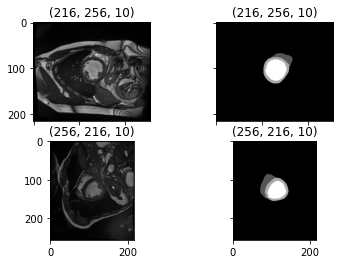

In [5]:
# Before

path_dataset = '../../../usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/acdc_bias_corr_original/' 
data_dir1 = path_dataset + 'patient001/patient001_frame01.nii.gz'
data_dir2 = path_dataset + 'patient001/patient001_frame01_gt.nii.gz'
data_dir3 = path_dataset + 'patient005/patient005_frame01.nii.gz'
data_dir4 = path_dataset + 'patient005/patient005_frame01_gt.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

In [6]:
# After

path_dataset = '../img_cropped/acdc/' 
data_dir1 = path_dataset + 'train/subject_1/img.nii.gz'
data_dir2 = path_dataset + 'train/subject_1/mask.nii.gz'
data_dir3 = path_dataset + 'validation/subject_5/img.nii.gz'
data_dir4 = path_dataset + 'validation/subject_5/mask.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

[0. 1. 2. 3.]


FileNotFoundError: No such file or no access: '../img_cropped/acdc/validation/subject_5/img.nii.gz'

In [ ]:
# Before

path_dataset = '../../../usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/acdc_bias_corr_cropped/' 
data_dir1 = path_dataset + 'patient001/img_cropped.nii.gz'
data_dir2 = path_dataset + 'patient001/mask_cropped.nii.gz'
data_dir3 = path_dataset + 'patient002/img_cropped.nii.gz'
data_dir4 = path_dataset + 'patient002/mask_cropped.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

In [ ]:
# After

path_dataset = '../img_cropped/acdc_krishna/train/' 
data_dir1 = path_dataset + 'subject_1/img.nii.gz'
data_dir2 = path_dataset + 'subject_1/mask.nii.gz'
data_dir3 = path_dataset + 'subject_10/img.nii.gz'
data_dir4 = path_dataset + 'subject_10/mask.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

In [ ]:
80 * 0.35

In [10]:
32/4

8.0

In [11]:
49/4

12.25